In [1]:

import random
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import json
import os

from sklearn.metrics import classification_report, roc_auc_score
from scipy import interpolate
from sklearn.metrics import roc_curve, auc
from cycler import cycler
# from awkward import ak

import uproot ## means uproot4
import sklearn.metrics as m

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)




In [2]:
CustNanoData = {
   
   
    'SingleMuon'   : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/SingleMuon/Tree_SingleMuon.root",
    # 'JetHT'        : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/Data/Tree_Data.root",            
    'QCD'    : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/MC/Tree_QCD.root",            
    # 'Signal' : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/Signal/Tree_Total.root",
    # 'GluGlu' : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/Signal/Tree_GluGlu.root",            
    # 'VH'     : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/Signal/Tree_VH.root",            
    # 'VBF'    : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/Signal/Tree_VBF.root",            
    # 'ttH'    : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/Signal/Tree_ttH.root",            
          
}
events = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    events[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" }) ## lazy means lazy computation style
    # for var in ak_arrays.fields:?
    #     if "HLT" in var or "FatJet" in var:
    #         events[year][var] = ak_arrays[var]

In [3]:
MAIN_DIR = ".."

plot_dir = f"{MAIN_DIR}/plots/trigger/8Mar24"
_ = os.system(f"mkdir -p {plot_dir}")

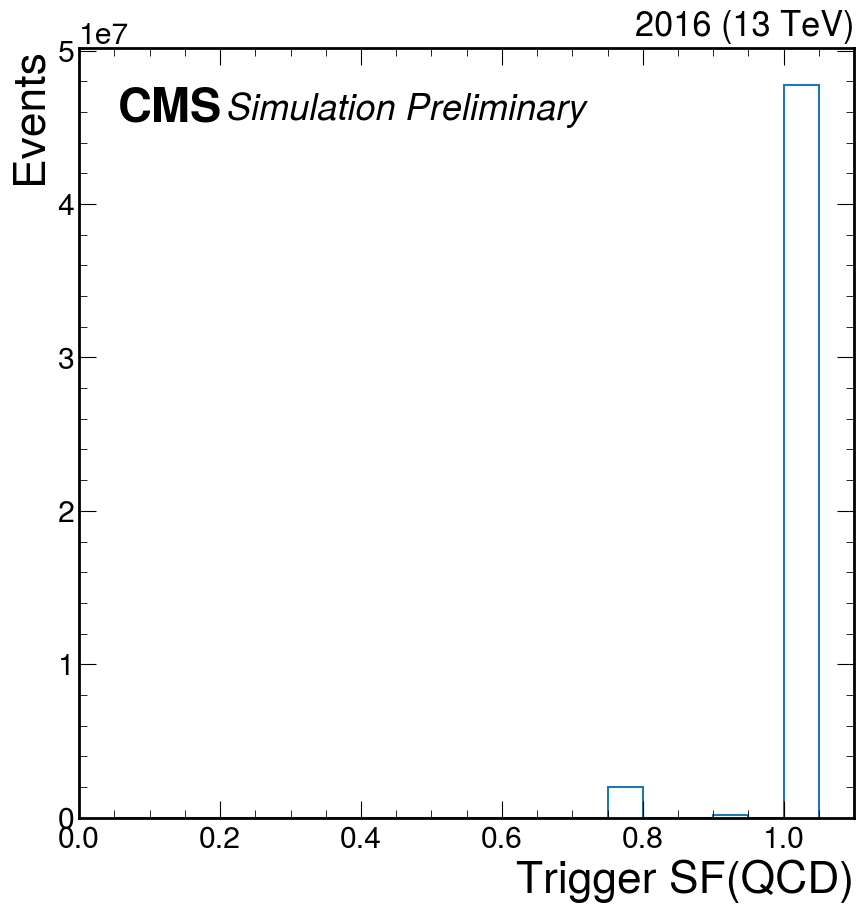

In [4]:
SFbins, SFmin, SFmax = 20, 0.05, 1.05
plt.figure(figsize=(10,10))
ax=plt.gca()
hep.cms.label(data= False, label = "Preliminary", year="2016", ax=ax, fontname='sans-serif', loc = 1)
hist1DSF = bh.Histogram(bh.axis.Regular(SFbins, SFmin, SFmax),storage=bh.storage.Weight())
hist1DSF.fill(events["QCD"]["TriggerSF"],weight = events["QCD"]["weight"])
h, err = hist1DSF.view().value, np.sqrt(hist1DSF.view().variance)
hep.histplot(h, bins=hist1DSF.axes[0].edges, yerr=err, histtype='step')
# plt.ylim(0, 6e7)
plt.xlabel(r"Trigger SF(QCD)", fontsize=32, ha='right', x=1)
plt.ylabel(r"Events", fontsize=32, ha='right', y = 1)
plt.savefig(f"{plot_dir}/2016QCDTriggerSF.pdf", bbox_inches='tight')
plt.show()

In [5]:
#Plot 2D trigger efficiency SFs unc.
def SF2DUnc_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2016", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (eventsMC["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (eventsMC["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (eventsMC["HLT_PFHT800"] == True) | (eventsMC["HLT_PFHT900"] == True) | (eventsMC["HLT_PFJet450"] == True) | (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet450"] == True) | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]* eventsMC_Cut["TriggerSF"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (eventsData["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (eventsData["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (eventsData["HLT_PFHT800"] == True) | (eventsData["HLT_PFHT900"] == True) | (eventsData["HLT_PFJet450"] == True) | (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet450"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


    Effi2DSF = EffiData2D/EffiMC2D


    #Start to calculate the uncentainty.
    Invera = 1./hist2DData_Cut.view().value
    Inverc = 1./hist2DData.view().value
    Inverb = 1./hist2DMC.view().value
    Inverd = 1./hist2DMC_Cut.view().value
    Sa = hist2DData_Cut.view().variance
    Sc = hist2DData.view().variance
    Sb = hist2DMC.view().variance
    Sd = hist2DMC_Cut.view().variance
                
    RelaUnc = np.sqrt( (Invera**2) * Sa + (Inverb**2) * Sb + (Inverc**2) * Sc + (Inverd**2) * Sd )
    Unc = Effi2DSF * RelaUnc
   
    #define mesh
    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Unc.T , vmin = 0, vmax = 1 )
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Unc
    # print(h)
    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2016_unc.json', 'w') as json_file:
        json.dump(meshed_value, json_file)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor uncertainty', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=32,color="black", x = 0.3, y = 0.9)

    plt.xlabel(r"Higgs candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Higgs candidate $p_{T}$", fontsize=32, ha='right', y=1)
    plt.savefig(f"{plot_dir}/2016Unc" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')

    plt.show()

/tmp/ipykernel_145250/1593153528.py:29: RuntimeWarning: invalid value encountered in divide
  EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value
/tmp/ipykernel_145250/1593153528.py:41: RuntimeWarning: invalid value encountered in divide
  EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value
/tmp/ipykernel_145250/1593153528.py:48: RuntimeWarning: divide by zero encountered in divide
  Invera = 1./hist2DData_Cut.view().value
/tmp/ipykernel_145250/1593153528.py:49: RuntimeWarning: divide by zero encountered in divide
  Inverc = 1./hist2DData.view().value
/tmp/ipykernel_145250/1593153528.py:50: RuntimeWarning: divide by zero encountered in divide
  Inverb = 1./hist2DMC.view().value
/tmp/ipykernel_145250/1593153528.py:51: RuntimeWarning: divide by zero encountered in divide
  Inverd = 1./hist2DMC_Cut.view().value
/tmp/ipykernel_145250/1593153528.py:57: RuntimeWarning: invalid value encountered in multiply
  RelaUnc = np.sqrt( (Invera**2) * Sa + (Inverb**2) * Sb + (In

When mass =  40.0  pT =  200.0 SF =  0.049138204377459326
When mass =  40.0  pT =  220.0 SF =  0.04751108368391118
When mass =  40.0  pT =  240.0 SF =  0.049391830120674045
When mass =  40.0  pT =  260.0 SF =  0.05208024204219761
When mass =  40.0  pT =  280.0 SF =  0.051484353782842995
When mass =  40.0  pT =  300.0 SF =  0.05120214540382655
When mass =  40.0  pT =  320.0 SF =  0.05194170035381226
When mass =  40.0  pT =  340.0 SF =  0.05031909025566892
When mass =  40.0  pT =  360.0 SF =  0.04881612956889372
When mass =  40.0  pT =  380.0 SF =  0.048919930165532116
When mass =  40.0  pT =  400.0 SF =  0.02735402652927322
When mass =  40.0  pT =  420.0 SF =  0.030039435040741923
When mass =  40.0  pT =  440.0 SF =  0.03283911045782885
When mass =  40.0  pT =  460.0 SF =  0.03747937358125244
When mass =  40.0  pT =  480.0 SF =  0.041716306134584054
When mass =  40.0  pT =  500.0 SF =  0.04507989873415122
When mass =  40.0  pT =  520.0 SF =  0.05279450948201394
When mass =  40.0  pT =  

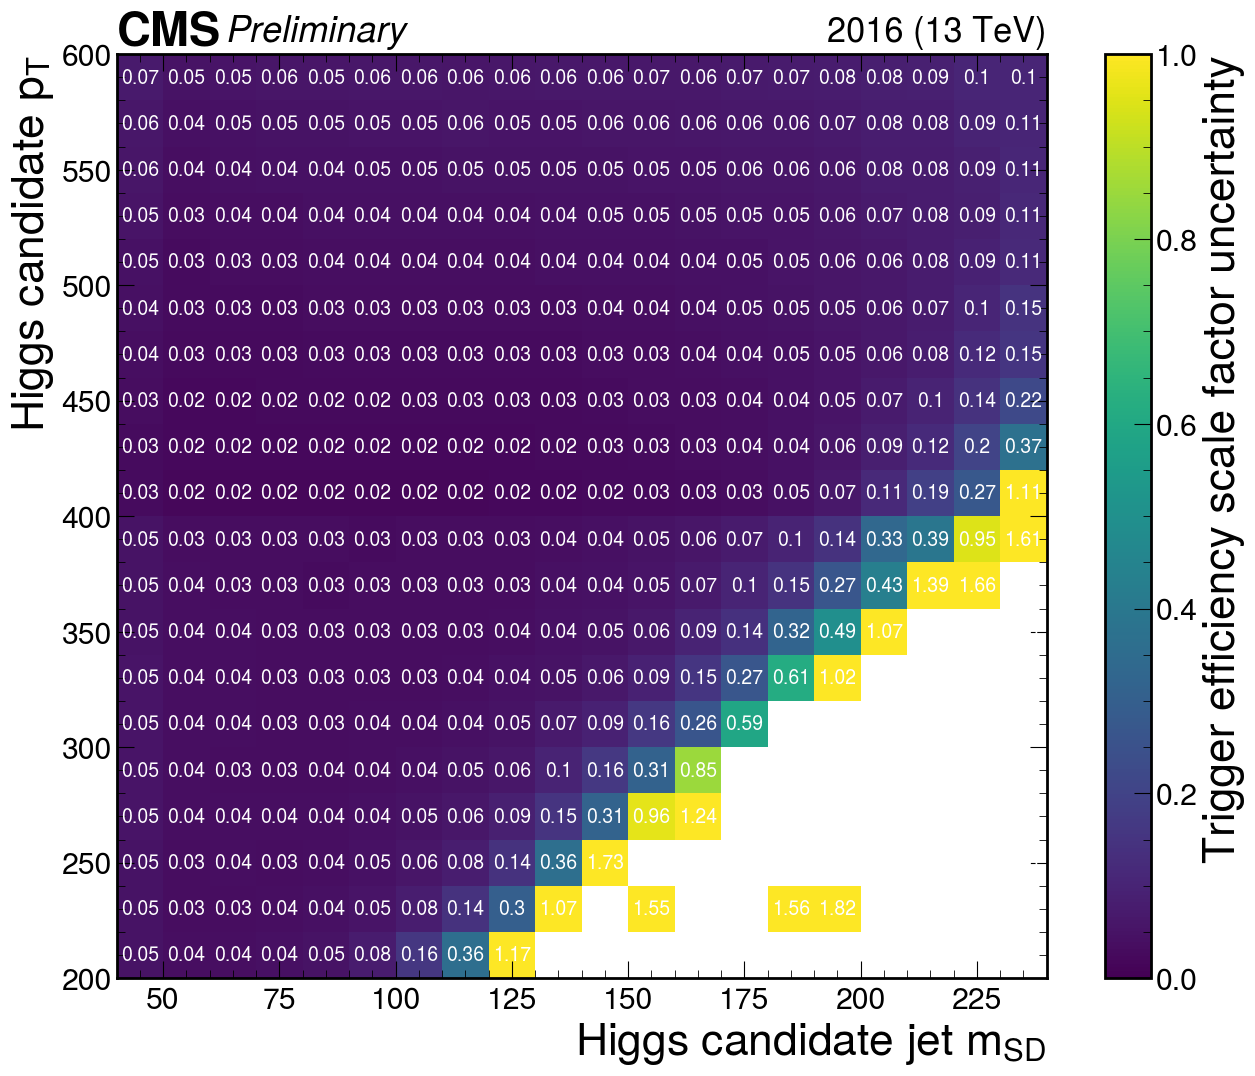

In [6]:
SF2DUnc_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"],x_label="Mja", y_label = "PTja",legend_location='lower right')

In [7]:
#Plot 2D trigger efficiency SFs.
def plot_effi_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2016", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (eventsMC["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (eventsMC["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (eventsMC["HLT_PFHT800"] == True) | (eventsMC["HLT_PFHT900"] == True) | (eventsMC["HLT_PFJet450"] == True) | (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet450"] == True) | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]* eventsMC_Cut["TriggerSF"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (eventsData["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (eventsData["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (eventsData["HLT_PFHT800"] == True) | (eventsData["HLT_PFHT900"] == True) | (eventsData["HLT_PFJet450"] == True) | (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet450"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


    Effi2DSF = EffiData2D/EffiMC2D

    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2DSF.T ,vmin = 0.8, vmax = 1.2)

  
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Effi2DSF
    # print(h)
    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2016.json', 'w') as json_file:
        json.dump(meshed_value, json_file)

    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=32,color="black", x = 0.3, y = 0.9)

    plt.xlabel(r"Higgs candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Higgs candidate $p_{T}$", fontsize=32, ha='right', y=1)
    # plt.savefig("./2DSFPlots/2016Max1p5" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')
    plt.savefig(f"{plot_dir}/2016WithValue" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_145250/1363345950.py:29: RuntimeWarning: invalid value encountered in divide
  EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value
/tmp/ipykernel_145250/1363345950.py:41: RuntimeWarning: invalid value encountered in divide
  EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


When mass =  40.0  pT =  200.0 SF =  1.0125823932200846
When mass =  40.0  pT =  220.0 SF =  0.9954325696652041
When mass =  40.0  pT =  240.0 SF =  0.9835722728288078
When mass =  40.0  pT =  260.0 SF =  1.0072589730646586
When mass =  40.0  pT =  280.0 SF =  1.0354593812316035
When mass =  40.0  pT =  300.0 SF =  1.03527546903643
When mass =  40.0  pT =  320.0 SF =  1.0335877472184025
When mass =  40.0  pT =  340.0 SF =  1.0586235665912596
When mass =  40.0  pT =  360.0 SF =  1.0435726355070272
When mass =  40.0  pT =  380.0 SF =  1.0681277898737225
When mass =  40.0  pT =  400.0 SF =  0.9706657525032433
When mass =  40.0  pT =  420.0 SF =  0.9937563910142867
When mass =  40.0  pT =  440.0 SF =  0.9965256413808327
When mass =  40.0  pT =  460.0 SF =  0.9904290844723797
When mass =  40.0  pT =  480.0 SF =  0.9950142263224797
When mass =  40.0  pT =  500.0 SF =  0.9991215730070627
When mass =  40.0  pT =  520.0 SF =  1.0002704138041099
When mass =  40.0  pT =  540.0 SF =  1.00023718235

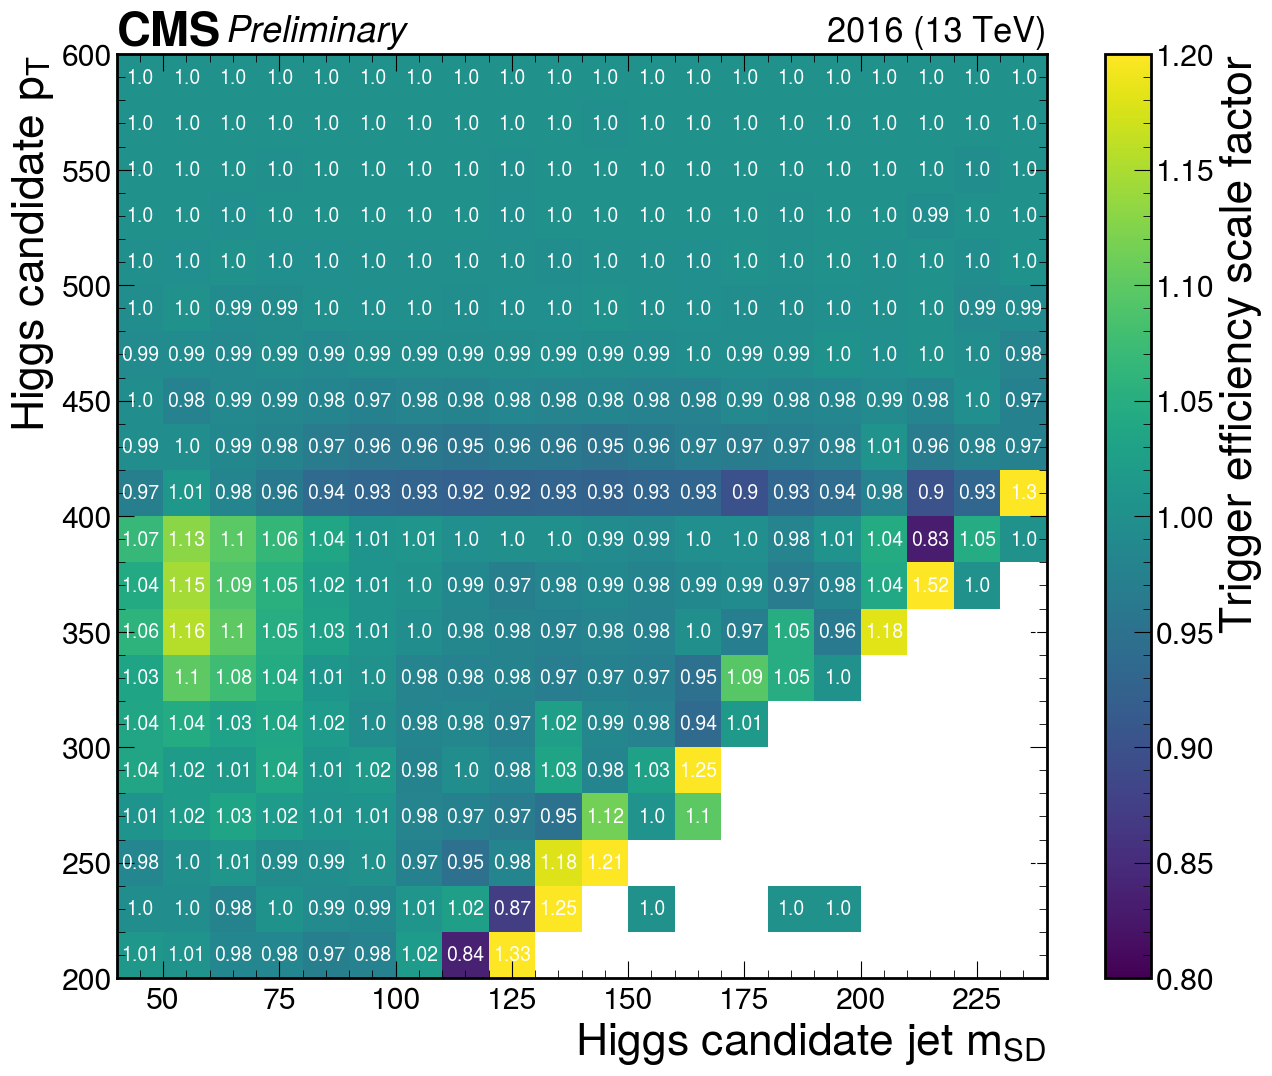

In [8]:
plot_effi_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"],x_label="Mja", y_label = "PTja",             xmin = 0, xmax = 300.0, bins = 300, legend_location='lower right')

### (optional) plot the 2D trigger efficiency distributionm

In [7]:
#Plot 2D trigger efficiency SFs.
def TriggerEff2D(eventsMC, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2016", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20

    if isData:
        eventsData = eventsMC

        hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

        eventsData_Cut = eventsData[ (eventsData["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (eventsData["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (eventsData["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (eventsData["HLT_PFHT800"] == True) | (eventsData["HLT_PFHT900"] == True) | (eventsData["HLT_PFJet450"] == True) | (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet450"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True)]

        hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

        Effi2D = hist2DData_Cut.view().value / hist2DData.view().value
        mesh = ax.pcolormesh(*hist2DData.axes.edges.T, Effi2D.T )
        
        xedges = hist2DData.axes[0].edges
        print(xedges)
        yedges = hist2DData.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
        
        Namesup = "SingleMuon:"
        namestr = "./2DSFPlots_Updated_07052023/2016DataEffi2D" + y_label + "_vs_" + x_label + ".pdf"

    else:
   
        hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])
    
        eventsMC_Cut = eventsMC[ (eventsMC["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (eventsMC["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (eventsMC["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (eventsMC["HLT_PFHT800"] == True) | (eventsMC["HLT_PFHT900"] == True) | (eventsMC["HLT_PFJet450"] == True) | (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet450"] == True) | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True)]
        
        hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])
    
        Effi2D = hist2DMC_Cut.view().value / hist2DMC.view().value
        mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2D.T )

        
        xedges = hist2DMC.axes[0].edges
        print(xedges)
        yedges = hist2DMC.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
   

        Namesup = "QCD:"
        namestr = "./2DSFPlots_Updated_07052023/2016QCDEffi2D" + y_label + "_vs_" + x_label + ".pdf"





    # plt.title('2D-Trigger Efficiency', fontsize=32,color="black", x = 0.3, y = 0.9)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency', rotation= 90,fontsize=32)
    plt.xlabel(Namesup + r"Higgs candidate jet $m_{SD}$", fontsize=20, ha='right', x=1)
    plt.ylabel(Namesup + r"Higgs candidate $p_{T}$", fontsize=20, ha='right', y=1)
    plt.savefig(namestr, bbox_inches='tight')

    plt.show()

/tmp/ipykernel_41820/370624639.py:32: RuntimeWarning: invalid value encountered in divide
  Effi2D = hist2DData_Cut.view().value / hist2DData.view().value


[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180. 190. 200. 210. 220. 230. 240.]
[200. 220. 240. 260. 280. 300. 320. 340. 360. 380. 400. 420. 440. 460.
 480. 500. 520. 540. 560. 580. 600.]
[[0.90102041 0.87693798 0.84909671 0.85231116 0.85227273 0.87100103
  0.87987013 0.91188119 0.90425532 0.93320611 0.76498573 0.87376726
  0.95179538 0.97612732 0.99090157 0.99806202 1.         1.
  1.         1.        ]
 [0.79567187 0.76717724 0.7512929  0.74379391 0.72067039 0.72343264
  0.74159292 0.77043121 0.78605016 0.82629108 0.65860825 0.79052282
  0.89620939 0.96653835 0.9925761  0.99532929 0.9994152  1.
  1.         1.        ]
 [0.79277244 0.76544357 0.76144578 0.76122254 0.73569845 0.74289643
  0.77803415 0.81337413 0.82122213 0.86893204 0.70322674 0.8192123
  0.9149938  0.96518684 0.98536375 0.99744376 0.99732441 1.
  1.         1.        ]
 [0.81617647 0.79650238 0.76507782 0.76301703 0.78101209 0.79851783
  0.83213321 0.85622593 0.88670757 0.92420961 0.763541

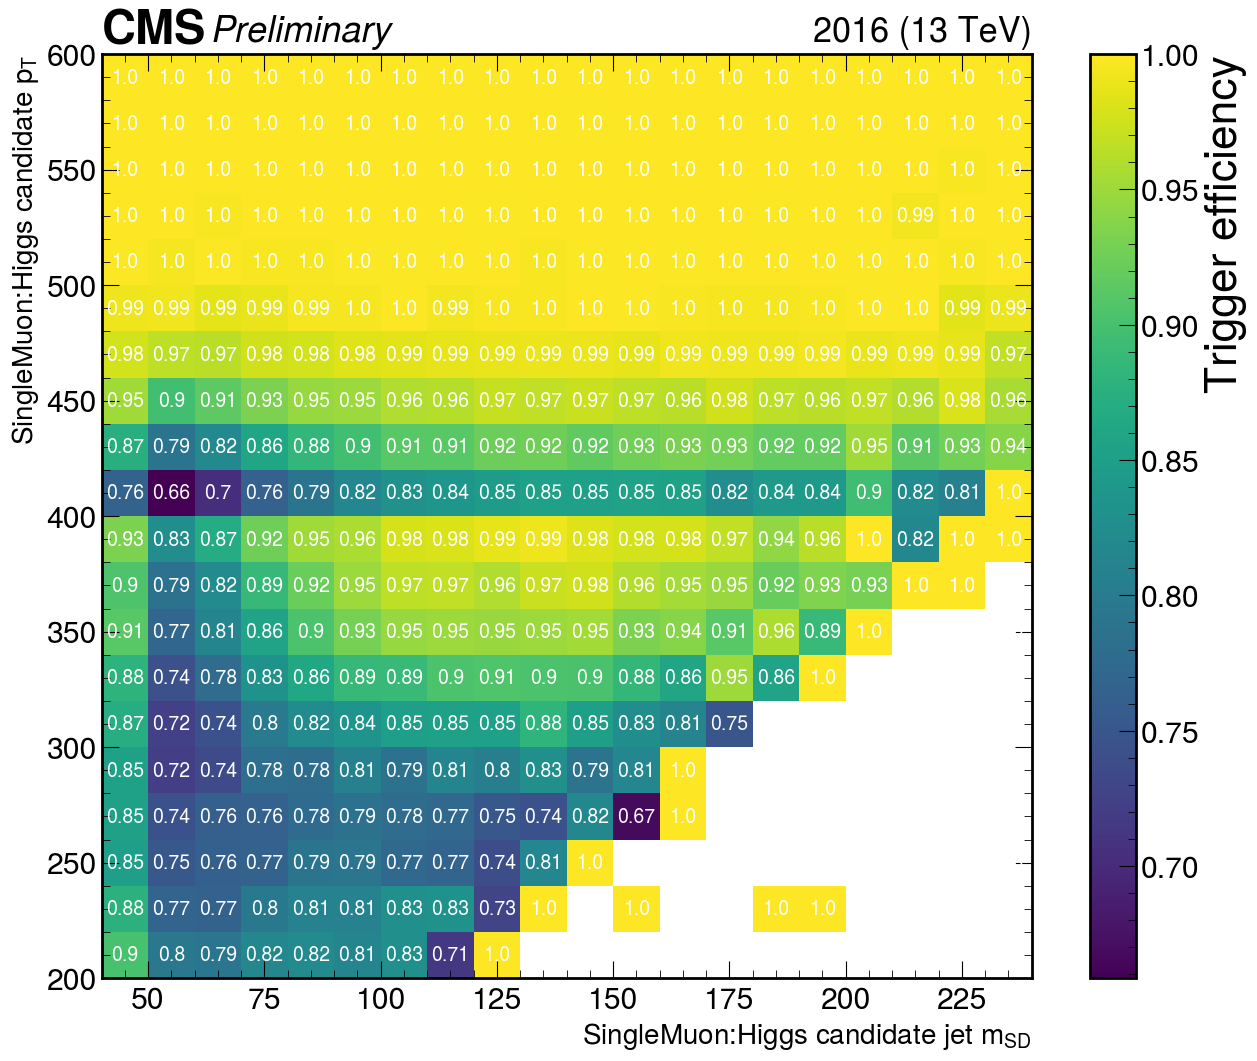

In [8]:
TriggerEff2D(eventsMC=events["SingleMuon"],isData = True,  x_label="Mja", y_label = "PTja",legend_location='lower right')


/tmp/ipykernel_41820/1829442832.py:59: RuntimeWarning: invalid value encountered in divide
  Effi2D = hist2DMC_Cut.view().value / hist2DMC.view().value


[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180. 190. 200. 210. 220. 230. 240.]
[200. 220. 240. 260. 280. 300. 320. 340. 360. 380. 400. 420. 440. 460.
 480. 500. 520. 540. 560. 580. 600.]
[[0.88982429 0.88096172 0.86327841 0.84616884 0.82308659 0.84132297
  0.85127763 0.8613838  0.86649965 0.87368395 0.78810417 0.879257
  0.95511378 0.98556003 0.99586674 0.99893951 0.99972966 0.99976287
  1.         1.        ]
 [0.7914031  0.77054462 0.75172467 0.72916627 0.70713744 0.69242393
  0.67380624 0.66687544 0.68545097 0.73119582 0.65064592 0.79389757
  0.91688665 0.97473162 0.99239549 0.99816902 0.99906998 0.99953943
  0.99988098 0.99997699]
 [0.80541543 0.78184082 0.75511531 0.7362958  0.72537197 0.72094956
  0.72317314 0.73904661 0.75490295 0.79176136 0.71625685 0.82981672
  0.9259746  0.97713731 0.99401944 0.99736654 0.99930631 0.99962991
  0.99982278 1.        ]
 [0.83024231 0.7950865  0.77065808 0.74909146 0.75239059 0.77011952
  0.79714171 0.81552398 0.84194

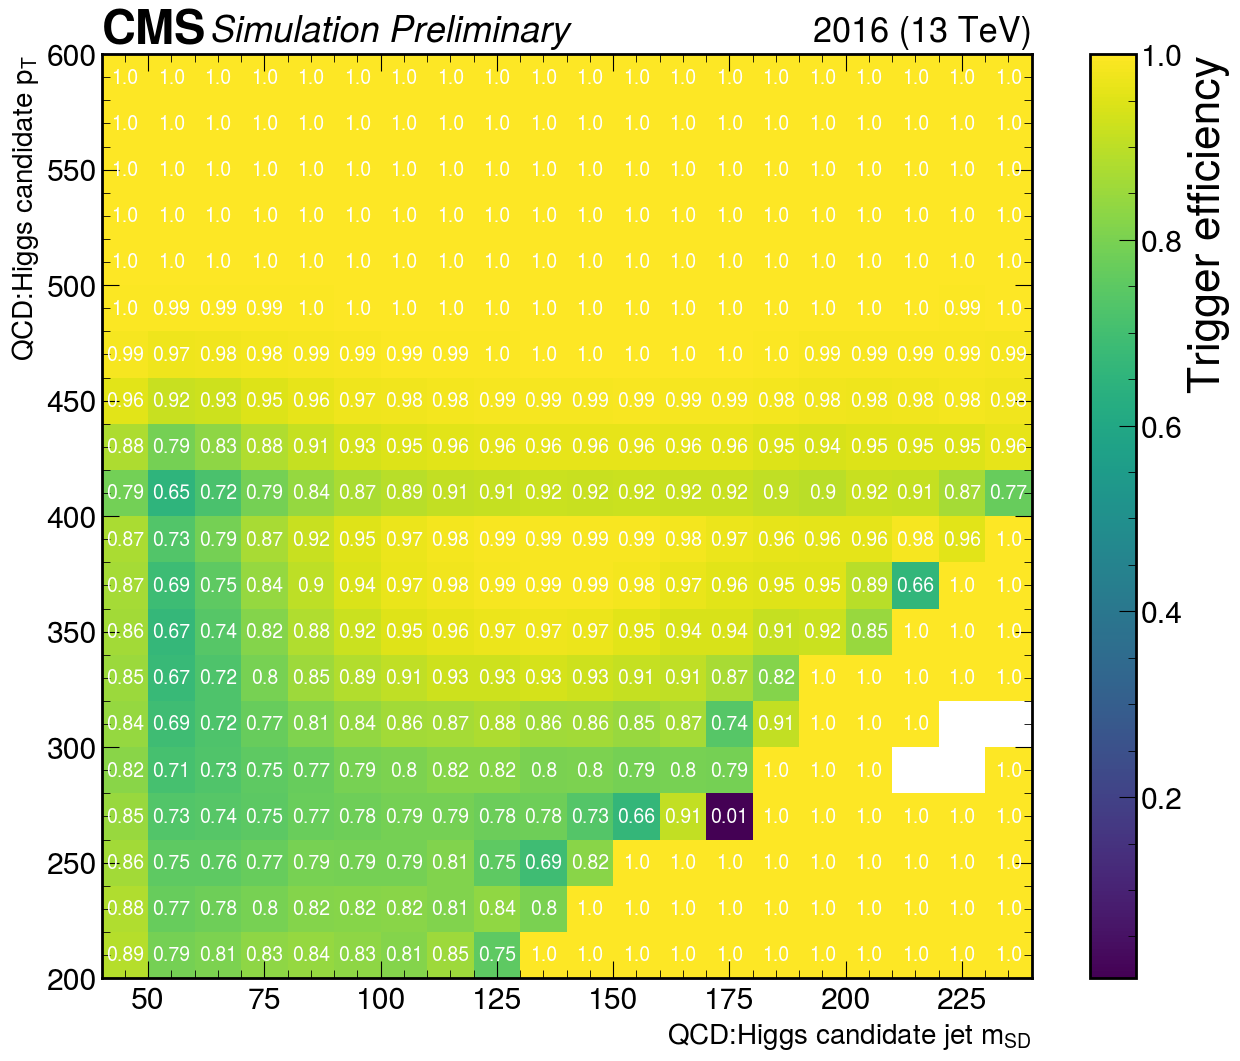

In [6]:
TriggerEff2D(eventsMC=events["QCD"],isData = False,  x_label="Mja", y_label = "PTja",legend_location='lower right')


In [1]:
(0.359**2 + 0.386**2 + 0.456**2 + 0.188**2 + 0.122**2 + 0.204**2)**0.5

0.7600374990748813